In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]
y = df['Whisky_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Define models and their parameter grids
models = [
    ('Linear Regression', LinearRegression(), {}),
    ('XGBoost', xgb.XGBRegressor(random_state=42, n_estimators=100), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}),
    ('LightGBM', lgb.LGBMRegressor(random_state=42, verbose=-1), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [-1, 10]}),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}),
    ('Support Vector Regression', SVR(), {'model__C': [0.5, 1, 10], 'model__gamma': ['scale', 'auto']}),
    ('CatBoost', cb.CatBoostRegressor(random_state=42, verbose=0), {'model__iterations': [500, 1000], 'model__learning_rate': [0.03, 0.05], 'model__depth': [6, 8]}),
    ('Random Forest', RandomForestRegressor(random_state=42), {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20]})
]

# Header
print("\033[1mModel Comparison: Regression on Whisky Scores\033[0m")
print("We’re testing 7 models. Higher \033[1mR²\033[0m and lower \033[1mNMSE\033[0m indicate better performance.\n")
print("="*65)

# Loop through and evaluate
for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    if param_grid:
        search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=5, cv=3, scoring='r2', random_state=42)
        start_time = time.time()
        search.fit(X_train, y_train)
        end_time = time.time()
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        best_model = pipeline
        best_params = "N/A"

    y_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    variance = np.var(y_train)
    nmse = mse / variance
    elapsed_time = end_time - start_time

    print(f"\033[1m{model_name}\033[0m")
    if best_params != "N/A":
        print(f"  ▸ Best Parameters:       {best_params}")
    print(f"  ▸ R² (Train Set):         \033[1m{r2:.2f}\033[0m")
    print(f"  ▸ NMSE (Train Set):       \033[1m{nmse:.2f}\033[0m")
    print(f"  ▸ RMSE (Train Set):       \033[1m{rmse:.2f}\033[0m")
    print(f"  ▸ MAE (Train Set):        \033[1m{mae:.2f}\033[0m")
    print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
    print("-" * 65)

Model Comparison: Regression on Whisky Scores
We’re testing 7 models. Higher R² and lower NMSE indicate better performance.

Linear Regression
  ▸ R² (Train Set):         0.27
  ▸ NMSE (Train Set):       0.73
  ▸ RMSE (Train Set):       4.92
  ▸ MAE (Train Set):        3.93
  ▸ Training Time:          0.0 seconds
-----------------------------------------------------------------
XGBoost
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1}
  ▸ R² (Train Set):         0.40
  ▸ NMSE (Train Set):       0.60
  ▸ RMSE (Train Set):       4.46
  ▸ MAE (Train Set):        3.54
  ▸ Training Time:          1.3 seconds
-----------------------------------------------------------------
LightGBM
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': -1, 'model__learning_rate': 0.1}
  ▸ R² (Train Set):         0.48
  ▸ NMSE (Train Set):       0.52
  ▸ RMSE (Train Set):       4.16
  ▸ MAE (Train Set):        3.27
  ▸ Training Ti

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]
y = df['Whisky_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Define LightGBM model and parameter grid
lgbm_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgbm_param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [-1, 5, 10, 20],
    'model__min_child_samples': [5, 10, 20, 50],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [0, 0.01, 0.1]
}

# Define CatBoost model and parameter grid
catboost_model = cb.CatBoostRegressor(random_state=42, verbose=0)
catboost_param_grid = {
    'model__iterations': [500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8],
    'model__l2_leaf_reg': [1, 3, 5, 7]
}

models = [
    ('LightGBM', lgbm_model, lgbm_param_grid),
    ('CatBoost', catboost_model, catboost_param_grid)
]

results = []

for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=3, scoring='r2', random_state=42, n_jobs=-1)

    print(f"\033[1mModel Comparison: {model_name} Regression on Whisky Scores\033[0m")
    print(f"Tuning {model_name} deeply. Higher \033[1mR²\033[0m and lower \033[1mNMSE\033[0m indicate better performance.\n")
    print("="*65)

    start_time = time.time()
    search.fit(X_train, y_train)
    end_time = time.time()

    best_model = search.best_estimator_
    best_params = search.best_params_

    # Evaluate the best model
    y_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    variance = np.var(y_train)
    nmse = mse / variance
    elapsed_time = end_time - start_time

    results.append((model_name, r2, nmse, rmse, mae, elapsed_time, best_params))

    print(f"  ▸ Best Parameters:       {best_params}")
    print(f"  ▸ R² (Train Set):         \033[1m{r2:.2f}\033[0m")
    print(f"  ▸ NMSE (Train Set):       \033[1m{nmse:.2f}\033[0m")
    print(f"  ▸ RMSE (Train Set):       \033[1m{rmse:.2f}\033[0m")
    print(f"  ▸ MAE (Train Set):        \033[1m{mae:.2f}\033[0m")
    print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
    print("-" * 65)

# Compare Results
print("\n\033[1mSummary of Model Performance\033[0m")
summary_df = pd.DataFrame(results, columns=['Model', 'R2', 'NMSE', 'RMSE', 'MAE', 'Training Time (s)', 'Best Params'])
print(summary_df[['Model', 'R2', 'NMSE', 'RMSE', 'MAE', 'Training Time (s)']])


Model Comparison: LightGBM Regression on Whisky Scores
Tuning LightGBM deeply. Higher R² and lower NMSE indicate better performance.

  ▸ Best Parameters:       {'model__subsample': 1.0, 'model__reg_lambda': 0, 'model__reg_alpha': 0, 'model__n_estimators': 100, 'model__min_child_samples': 10, 'model__max_depth': -1, 'model__learning_rate': 0.2, 'model__colsample_bytree': 1.0}
  ▸ R² (Train Set):         0.48
  ▸ NMSE (Train Set):       0.52
  ▸ RMSE (Train Set):       4.14
  ▸ MAE (Train Set):        3.25
  ▸ Training Time:          185.1 seconds
-----------------------------------------------------------------
Model Comparison: CatBoost Regression on Whisky Scores
Tuning CatBoost deeply. Higher R² and lower NMSE indicate better performance.

  ▸ Best Parameters:       {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 500, 'model__depth': 8}
  ▸ R² (Train Set):         0.48
  ▸ NMSE (Train Set):       0.52
  ▸ RMSE (Train Set):       4.15
  ▸ MAE (Train Set): 

Further Improvement: LightGBM Regression on Whisky Scores
Hard-coded parameters applied, now adding feature engineering. Higher R² and lower NMSE indicate better performance.


Training Performance:
  ▸ R² (Train Set):         0.49
  ▸ NMSE (Train Set):       0.51
  ▸ RMSE (Train Set):       4.11
  ▸ MAE (Train Set):        3.22

Test Performance:
  ▸ R² (Test Set):          0.39
  ▸ NMSE (Test Set):        0.61
  ▸ RMSE (Test Set):        4.52
  ▸ MAE (Test Set):         3.53

  ▸ Training Time:          1.7 seconds
-----------------------------------------------------------------

Top 10 Important Features:
                        Feature  Importance
2                  Whisky_Price        5028
0          Whisky_Age_Corrected        3637
1                    Whisky_ABV        3391
8         Age_Price_Interaction        3143
5         ABV_Price_Interaction        3130
168      Whisky_Region_Highland         373
173      Whisky_Region_Speyside         325
4                     Whisky_OB

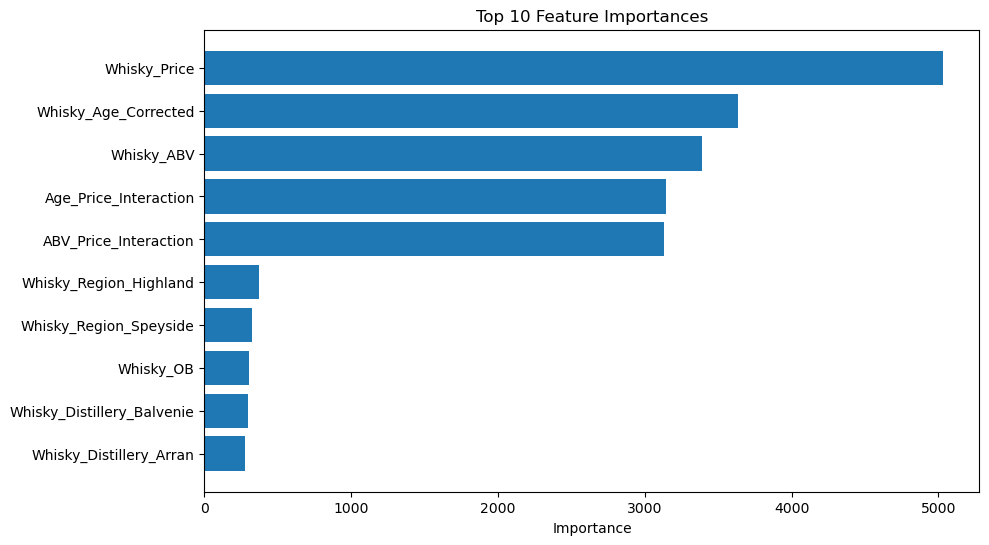

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import matplotlib.pyplot as plt

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

# Feature Engineering
df['ABV_Price_Interaction'] = df['Whisky_ABV'] * df['Whisky_Price']
df['ABV_Squared'] = df['Whisky_ABV'] ** 2
df['Log_Whisky_Price'] = np.log1p(df['Whisky_Price'])
df['Age_Price_Interaction'] = df['Whisky_Age_Corrected'] * df['Whisky_Price']

numeric_columns = [
    'Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB',
    'ABV_Price_Interaction', 'ABV_Squared', 'Log_Whisky_Price', 'Age_Price_Interaction'
]
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]
y = df['Whisky_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Define LightGBM model with hard-coded best parameters
lgbm_model = lgb.LGBMRegressor(
    random_state=42,
    verbose=-1,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    min_child_samples=10,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0,
    reg_lambda=0
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

print("\033[1mFurther Improvement: LightGBM Regression on Whisky Scores\033[0m")
print("Hard-coded parameters applied, now adding feature engineering. Higher \033[1mR²\033[0m and lower \033[1mNMSE\033[0m indicate better performance.\n")
print("="*65)

start_time = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

lgbm_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    eval_metric='rmse'
)
end_time = time.time()

# Evaluate the best model on training data
y_pred_train = lgbm_model.predict(X_train_preprocessed)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
variance_train = np.var(y_train)
nmse_train = mse_train / variance_train

# Evaluate the best model on test data
y_pred_test = lgbm_model.predict(X_test_preprocessed)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
variance_test = np.var(y_test)
nmse_test = mse_test / variance_test

elapsed_time = end_time - start_time

print(f"\nTraining Performance:")
print(f"  ▸ R² (Train Set):         \033[1m{r2_train:.2f}\033[0m")
print(f"  ▸ NMSE (Train Set):       \033[1m{nmse_train:.2f}\033[0m")
print(f"  ▸ RMSE (Train Set):       \033[1m{rmse_train:.2f}\033[0m")
print(f"  ▸ MAE (Train Set):        \033[1m{mae_train:.2f}\033[0m")

print(f"\nTest Performance:")
print(f"  ▸ R² (Test Set):          \033[1m{r2_test:.2f}\033[0m")
print(f"  ▸ NMSE (Test Set):        \033[1m{nmse_test:.2f}\033[0m")
print(f"  ▸ RMSE (Test Set):        \033[1m{rmse_test:.2f}\033[0m")
print(f"  ▸ MAE (Test Set):         \033[1m{mae_test:.2f}\033[0m")

print(f"\n  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
print("-" * 65)

# Report Feature Importance
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns))
importances = lgbm_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nTop 10 Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.show()


Class Distribution (0=Low, 1=Middle, 2=High):
Whisky_Score
0    3941
1    3082
2    3254
Name: count, dtype: int64
Score Cutoffs:
Low: <= 12.0, Middle: > 12.0 and <= 17.0, High: > 17.0
Converted Score Cutoffs (x / 10 + 7):
Low: <= 8.2, Middle: > 8.2 and <= 8.7, High: > 8.7
Model Comparison: Classification on Whisky Score Buckets
We’re testing 7 models. Higher Accuracy indicates better performance.

Logistic Regression
  ▸ Accuracy (Train Set):   0.53
  ▸ Training Time:          0.1 seconds
-----------------------------------------------------------------


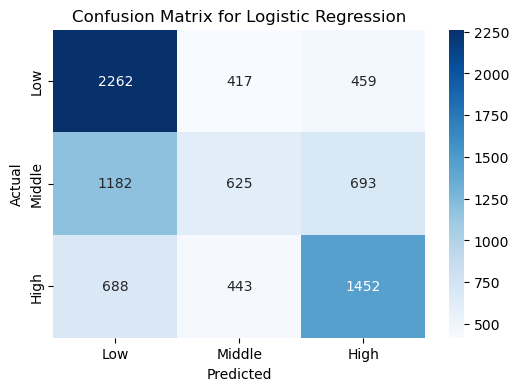

XGBoost
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1}
  ▸ Accuracy (Train Set):   0.59
  ▸ Training Time:          3.4 seconds
-----------------------------------------------------------------


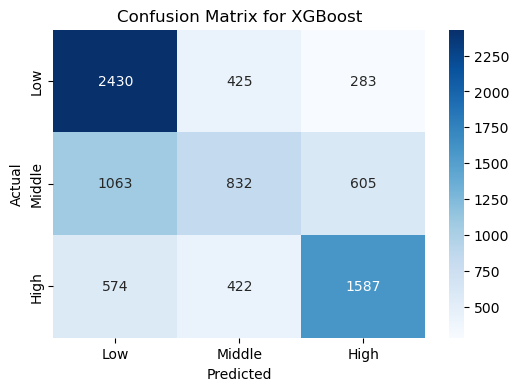

LightGBM
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': 10, 'model__learning_rate': 0.1}
  ▸ Accuracy (Train Set):   0.62
  ▸ Training Time:          9.6 seconds
-----------------------------------------------------------------


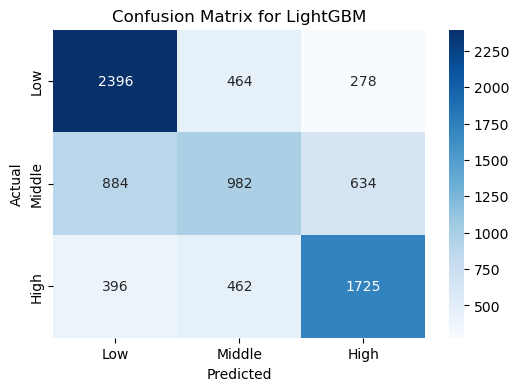

Gradient Boosting
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1}
  ▸ Accuracy (Train Set):   0.60
  ▸ Training Time:          28.1 seconds
-----------------------------------------------------------------


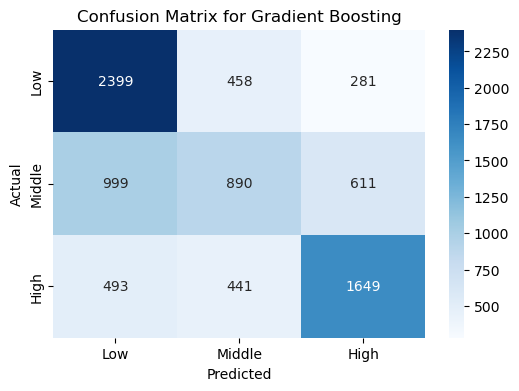

Support Vector Classifier
  ▸ Best Parameters:       {'model__gamma': 'scale', 'model__C': 10}
  ▸ Accuracy (Train Set):   0.59
  ▸ Training Time:          13.2 seconds
-----------------------------------------------------------------


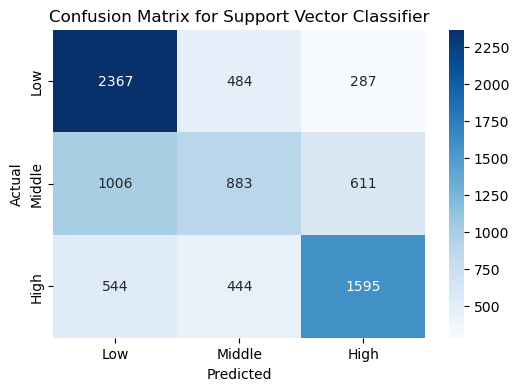

CatBoost
  ▸ Best Parameters:       {'model__learning_rate': 0.03, 'model__iterations': 1000, 'model__depth': 6}
  ▸ Accuracy (Train Set):   0.60
  ▸ Training Time:          22.8 seconds
-----------------------------------------------------------------


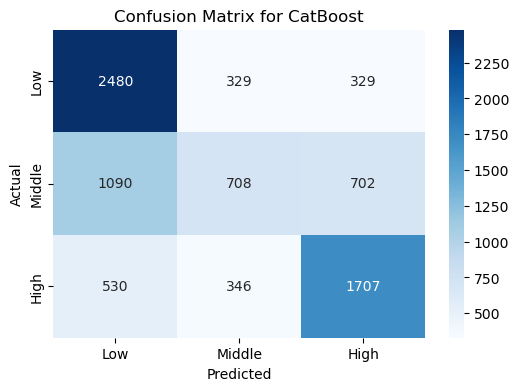

Random Forest
  ▸ Best Parameters:       {'model__n_estimators': 200, 'model__max_depth': None}
  ▸ Accuracy (Train Set):   0.62
  ▸ Training Time:          20.7 seconds
-----------------------------------------------------------------


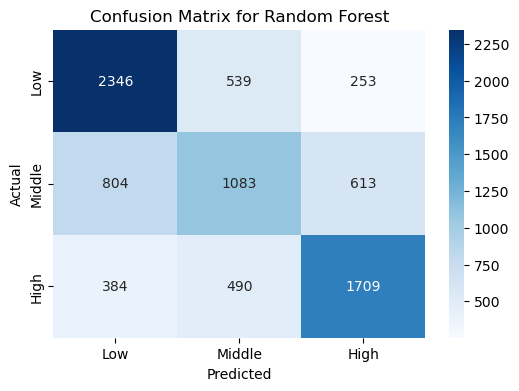

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]

# Bucketize the Whisky Score
y, bins = pd.qcut(df['Whisky_Score'], q=3, labels=[0, 1, 2], retbins=True)

# Analyze class distribution
class_distribution = y.value_counts().sort_index()
print("\033[1mClass Distribution (0=Low, 1=Middle, 2=High):\033[0m")
print(class_distribution)
print("\033[1mScore Cutoffs:\033[0m")
print(f"Low: <= {bins[1]:.1f}, Middle: > {bins[1]:.1f} and <= {bins[2]:.1f}, High: > {bins[2]:.1f}")
print("\033[1mConverted Score Cutoffs (x / 10 + 7):\033[0m")
print(f"Low: <= {bins[1]/10+7:.1f}, Middle: > {bins[1]/10+7:.1f} and <= {bins[2]/10+7:.1f}, High: > {bins[2]/10+7:.1f}")
print("="*65)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Define models and their parameter grids
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000), {}),
    ('XGBoost', xgb.XGBClassifier(random_state=42, n_estimators=100), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}),
    ('LightGBM', lgb.LGBMClassifier(random_state=42, verbose=-1), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [-1, 10]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}),
    ('Support Vector Classifier', SVC(), {'model__C': [0.5, 1, 10], 'model__gamma': ['scale', 'auto']}),
    ('CatBoost', cb.CatBoostClassifier(random_state=42, verbose=0), {'model__iterations': [500, 1000], 'model__learning_rate': [0.03, 0.05], 'model__depth': [6, 8]}),
    ('Random Forest', RandomForestClassifier(random_state=42), {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20]})
]

# Header
print("\033[1mModel Comparison: Classification on Whisky Score Buckets\033[0m")
print("We’re testing 7 models. Higher \033[1mAccuracy\033[0m indicates better performance.\n")
print("="*65)

# Loop through and evaluate
for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    if param_grid:
        search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=5, cv=3, scoring='accuracy', random_state=42)
        start_time = time.time()
        search.fit(X_train, y_train)
        end_time = time.time()
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        best_model = pipeline
        best_params = "N/A"

    y_pred = best_model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    elapsed_time = end_time - start_time

    print(f"\033[1m{model_name}\033[0m")
    if best_params != "N/A":
        print(f"  ▸ Best Parameters:       {best_params}")
    print(f"  ▸ Accuracy (Train Set):   \033[1m{acc:.2f}\033[0m")
    print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
    print("-" * 65)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_train, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Class Distribution (0=Low, 1=Middle, 2=High):
Whisky_Score
0    3941
1    3082
2    3254
Name: count, dtype: int64
Score Cutoffs:
Low: <= 12.0, Middle: > 12.0 and <= 17.0, High: > 17.0
Converted Score Cutoffs (x / 10 + 7):
Low: <= 8.2, Middle: > 8.2 and <= 8.7, High: > 8.7
Model Comparison: LightGBM Classification on Whisky Score Buckets
Tuning LightGBM deeply. Higher Accuracy indicates better performance.

  ▸ Best Parameters:       {'model__subsample': 0.6, 'model__reg_lambda': 0.01, 'model__reg_alpha': 0, 'model__n_estimators': 500, 'model__min_child_samples': 10, 'model__max_depth': 15, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6}
  ▸ Accuracy (Train Set):   0.62
  ▸ Training Time:          828.5 seconds
-----------------------------------------------------------------


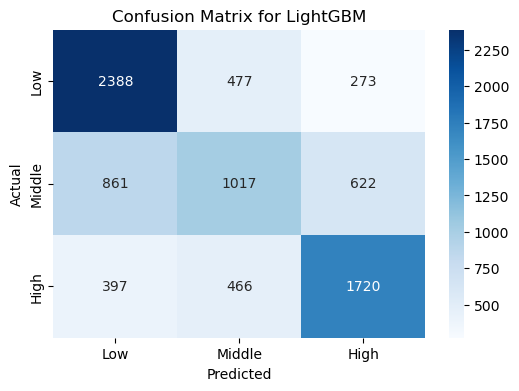

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]

# Bucketize the Whisky Score
y, bins = pd.qcut(df['Whisky_Score'], q=3, labels=[0, 1, 2], retbins=True)

# Analyze class distribution
class_distribution = y.value_counts().sort_index()
print("\033[1mClass Distribution (0=Low, 1=Middle, 2=High):\033[0m")
print(class_distribution)
print("\033[1mScore Cutoffs:\033[0m")
print(f"Low: <= {bins[1]:.1f}, Middle: > {bins[1]:.1f} and <= {bins[2]:.1f}, High: > {bins[2]:.1f}")
print("\033[1mConverted Score Cutoffs (x / 10 + 7):\033[0m")
print(f"Low: <= {bins[1]/10+7:.1f}, Middle: > {bins[1]/10+7:.1f} and <= {bins[2]/10+7:.1f}, High: > {bins[2]/10+7:.1f}")
print("="*65)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Define LightGBM model and parameter grid
model_name = 'LightGBM'
model = lgb.LGBMClassifier(random_state=42, verbose=-1)
param_grid = {
    'model__n_estimators': [100, 300, 500, 700],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [-1, 5, 10, 15],
    'model__min_child_samples': [5, 10, 20],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [0, 0.01, 0.1]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

print("\033[1mModel Comparison: LightGBM Classification on Whisky Score Buckets\033[0m")
print("Tuning LightGBM deeply. Higher \033[1mAccuracy\033[0m indicates better performance.\n")
print("="*65)

start_time = time.time()
search.fit(X_train, y_train)
end_time = time.time()

best_model = search.best_estimator_
best_params = search.best_params_

y_pred = best_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
elapsed_time = end_time - start_time

print(f"  ▸ Best Parameters:       {best_params}")
print(f"  ▸ Accuracy (Train Set):   \033[1m{acc:.2f}\033[0m")
print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
print("-" * 65)

# Plot Confusion Matrix
cm = confusion_matrix(y_train, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Class Distribution (0=Low, 1=Middle, 2=High):
Whisky_Score
0    3941
1    3082
2    3254
Name: count, dtype: int64
LightGBM Model: Classification on Whisky Score Buckets
Hard-coded best parameters applied with feature engineering and SMOTE. Higher Accuracy indicates better performance.

  ▸ Accuracy (Train Set):   0.62
  ▸ Training Time:          3.9 seconds
-----------------------------------------------------------------
  ▸ Accuracy (Test Set):    0.55
-----------------------------------------------------------------


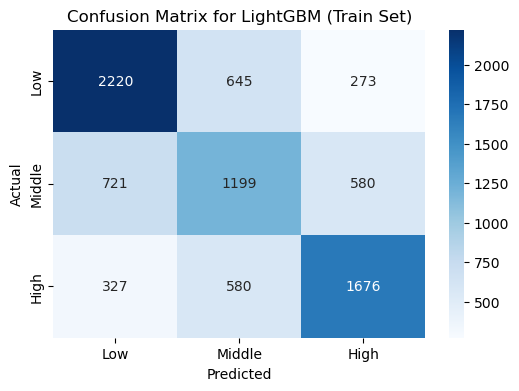

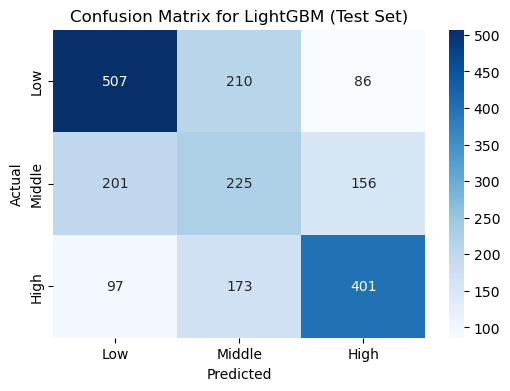


Top 10 Important Features:
                  Feature  Importance
2            Whisky_Price       10428
0    Whisky_Age_Corrected        9394
1              Whisky_ABV        7834
5   ABV_Price_Interaction        6409
8   Age_Price_Interaction        6024
10    Price_vs_Region_Avg        4554
12      ABV_vs_Region_Avg        3267
7        Log_Whisky_Price        2735
6             ABV_Squared        1303
4               Whisky_OB         920


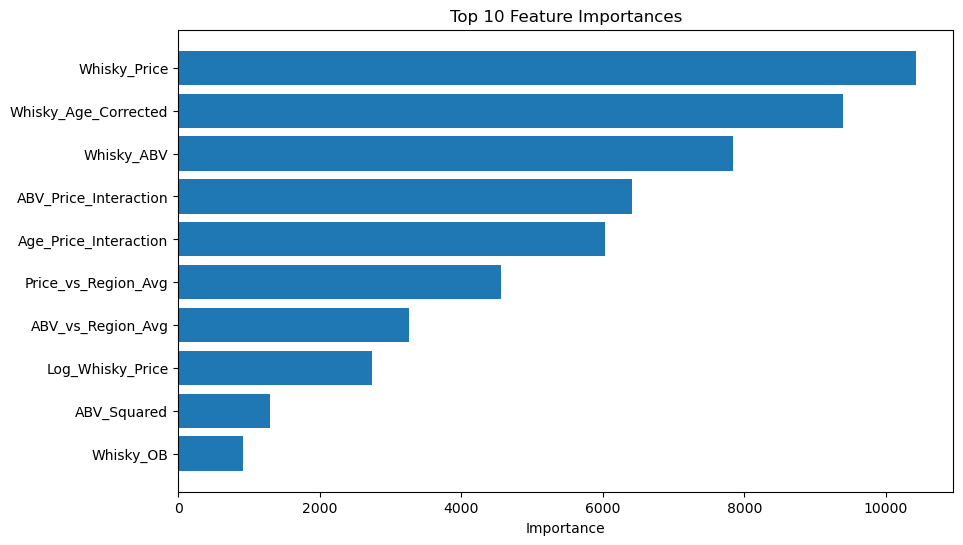

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

# Feature Engineering
df['ABV_Price_Interaction'] = df['Whisky_ABV'] * df['Whisky_Price']
df['ABV_Squared'] = df['Whisky_ABV'] ** 2
df['Log_Whisky_Price'] = np.log1p(df['Whisky_Price'])
df['Age_Price_Interaction'] = df['Whisky_Age_Corrected'] * df['Whisky_Price']
region_price_avg = df.groupby('Whisky_Region')['Whisky_Price'].transform('mean')
df['Region_Price_Avg'] = region_price_avg
df['Price_vs_Region_Avg'] = df['Whisky_Price'] - region_price_avg
df['Region_ABV_Avg'] = df.groupby('Whisky_Region')['Whisky_ABV'].transform('mean')
df['ABV_vs_Region_Avg'] = df['Whisky_ABV'] - df['Region_ABV_Avg']

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB',
                   'ABV_Price_Interaction', 'ABV_Squared', 'Log_Whisky_Price', 'Age_Price_Interaction',
                   'Region_Price_Avg', 'Price_vs_Region_Avg', 'Region_ABV_Avg', 'ABV_vs_Region_Avg']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]

# Bucketize the Whisky Score
y = pd.qcut(df['Whisky_Score'], q=3, labels=[0, 1, 2])

# Analyze class distribution
class_distribution = y.value_counts().sort_index()
print("\033[1mClass Distribution (0=Low, 1=Middle, 2=High):\033[0m")
print(class_distribution)
print("="*65)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Preprocess and apply SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define LightGBM with hard-coded best parameters
lgbm_model = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    class_weight='balanced',
    subsample=1.0,
    n_estimators=1000,
    min_child_samples=5,
    max_depth=10,
    learning_rate=0.5,
    colsample_bytree=0.8
)

# Header
print("\033[1mLightGBM Model: Classification on Whisky Score Buckets\033[0m")
print("Hard-coded best parameters applied with feature engineering and SMOTE. Higher \033[1mAccuracy\033[0m indicates better performance.\n")
print("="*65)

start_time = time.time()
lgbm_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

# Evaluate the model on training set
y_pred_train = lgbm_model.predict(X_train_processed)
acc_train = accuracy_score(y_train, y_pred_train)
elapsed_time = end_time - start_time

print(f"  ▸ Accuracy (Train Set):   \033[1m{acc_train:.2f}\033[0m")
print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
print("-" * 65)

# Evaluate the model on test set
y_pred_test = lgbm_model.predict(X_test_processed)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"  ▸ Accuracy (Test Set):    \033[1m{acc_test:.2f}\033[0m")
print("-" * 65)

# Plot Confusion Matrix for training set
cm_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
plt.title('Confusion Matrix for LightGBM (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Confusion Matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
plt.title('Confusion Matrix for LightGBM (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Report Feature Importance
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns))
importances = lgbm_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nTop 10 Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.show()


Class Distribution (0=Low, 1=Middle, 2=High):
Whisky_Score
0    3941
1    3082
2    3254
Name: count, dtype: int64
LightGBM + XGBoost + CatBoost + RF + SVC + Logistic Regression Weighted Ensemble: Classification on Whisky Score Buckets
Hard-coded best parameters applied with feature engineering and SMOTE. Higher Accuracy indicates better performance.

  ▸ Accuracy (Train Set):   0.61
  ▸ Training Time:          16.2 seconds
-----------------------------------------------------------------
  ▸ Accuracy (Test Set):    0.56
-----------------------------------------------------------------


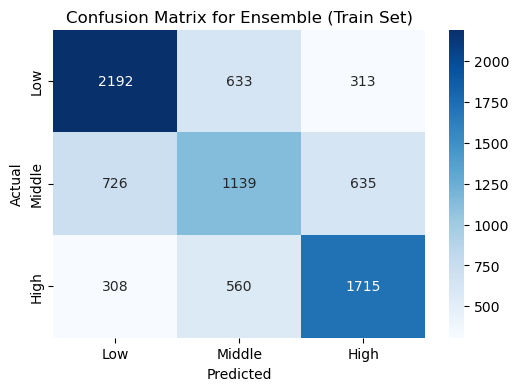

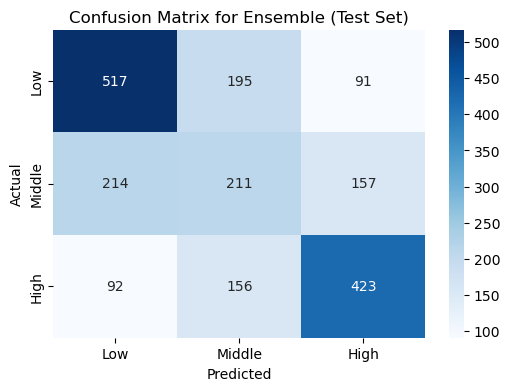

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import time

import Data_Loading

# Load and prepare data
df = Data_Loading.load_whisky_data(
    remove_guests=True,
    remove_USwhiskies=False,
    remove_thresh=7,
    pointscale=True,
    fill_missing_age=True,
    min_whiskies_per_region=10
)

# Feature Engineering
df['ABV_Price_Interaction'] = df['Whisky_ABV'] * df['Whisky_Price']
df['ABV_Squared'] = df['Whisky_ABV'] ** 2
df['Log_Whisky_Price'] = np.log1p(df['Whisky_Price'])
df['Age_Price_Interaction'] = df['Whisky_Age_Corrected'] * df['Whisky_Price']
region_price_avg = df.groupby('Whisky_Region')['Whisky_Price'].transform('mean')
df['Region_Price_Avg'] = region_price_avg
df['Price_vs_Region_Avg'] = df['Whisky_Price'] - region_price_avg
df['Region_ABV_Avg'] = df.groupby('Whisky_Region')['Whisky_ABV'].transform('mean')
df['ABV_vs_Region_Avg'] = df['Whisky_ABV'] - df['Region_ABV_Avg']

numeric_columns = ['Whisky_Age_Corrected', 'Whisky_ABV', 'Whisky_Price', 'Age_Missing', 'Whisky_OB',
                   'ABV_Price_Interaction', 'ABV_Squared', 'Log_Whisky_Price', 'Age_Price_Interaction',
                   'Region_Price_Avg', 'Price_vs_Region_Avg', 'Region_ABV_Avg', 'ABV_vs_Region_Avg']
categorical_columns = ['Whisky_Distillery', 'Whisky_Region']
X = df[numeric_columns + categorical_columns]

# Bucketize the Whisky Score
y = pd.qcut(df['Whisky_Score'], q=3, labels=[0, 1, 2])

# Analyze class distribution
class_distribution = y.value_counts().sort_index()
print("\033[1mClass Distribution (0=Low, 1=Middle, 2=High):\033[0m")
print(class_distribution)
print("="*65)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Preprocess and apply SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define individual models
lgbm_model = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    class_weight='balanced',
    subsample=1.0,
    n_estimators=200,
    min_child_samples=5,
    max_depth=10,
    learning_rate=0.1,
    colsample_bytree=0.8
)

xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

cat_model = cb.CatBoostClassifier(
    random_state=42,
    iterations=200,
    depth=10,
    learning_rate=0.1,
    verbose=0
)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
svc_model = SVC(probability=True, random_state=42)
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Create Weighted Voting Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('rf', rf_model),
        ('svc', svc_model),
        ('log', log_model)
    ],
    voting='soft',
    weights=[2, 1, 1, 1, 0.5, 0.5]  # Give LightGBM more influence
)

# Header
print("\033[1mLightGBM + XGBoost + CatBoost + RF + SVC + Logistic Regression Weighted Ensemble: Classification on Whisky Score Buckets\033[0m")
print("Hard-coded best parameters applied with feature engineering and SMOTE. Higher \033[1mAccuracy\033[0m indicates better performance.\n")
print("="*65)

start_time = time.time()
ensemble.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

# Evaluate the model on training set
y_pred_train = ensemble.predict(X_train_processed)
acc_train = accuracy_score(y_train, y_pred_train)
elapsed_time = end_time - start_time

print(f"  ▸ Accuracy (Train Set):   \033[1m{acc_train:.2f}\033[0m")
print(f"  ▸ Training Time:          \033[1m{elapsed_time:.1f} seconds\033[0m")
print("-" * 65)

# Evaluate the model on test set
y_pred_test = ensemble.predict(X_test_processed)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"  ▸ Accuracy (Test Set):    \033[1m{acc_test:.2f}\033[0m")
print("-" * 65)

# Plot Confusion Matrix for training set
cm_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
plt.title('Confusion Matrix for Ensemble (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Confusion Matrix for test set
cm_test = confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Middle', 'High'], yticklabels=['Low', 'Middle', 'High'])
plt.title('Confusion Matrix for Ensemble (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
